In [1]:
import argparse
import os
import shutil
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data

import datasets
import models as models

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt

## 3(a) PlainNet 8

### Train PlainNet8

In [ ]:
! python main.py -a plainnet8 2>&1 | tee log_plain8.txt

### Load trained model

In [2]:
model = models.__dict__['plainnet8'](16,10)

In [3]:
checkpoint = torch.load('checkpoint_plain8.pth.tar')
state_dict = checkpoint['state_dict']

In [4]:
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove 'module.' of dataparallel
    new_state_dict[name]=v

model.load_state_dict(new_state_dict)

### Find 1,3,5,7 layer

In [14]:
model.conv1 # layer 1 before BN

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [18]:
model.layer1[0].conv2 # layer 3 before BN

Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [19]:
model.layer2[0].conv2 # layer 5 before BN

Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [20]:
model.layer3[0].conv2 # layer 7 before BN

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

### Create first 10 test data

In [5]:
test_loader = torch.utils.data.DataLoader(
            datasets.CIFAR10(
                root='./cifar10/test', train=False, download=True,
                transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                ])),
            batch_size=10, shuffle=False)

Files already downloaded and verified


In [6]:
inputs, labels = next(iter(test_loader))
inputs, labels = Variable(inputs), Variable(labels)

### Using hook to record hidden layer output 

In [7]:
class Hook():
    '''
    A simple hook class that returns the input and output of a layer during forward/backward pass
    '''
    def __init__(self, module, backward=False):
        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()

In [8]:
hook1 = Hook(model.conv1) # register layer 1 on hook
hook3 = Hook(model.layer1[0].conv2) # register layer 3 on hook
hook5 = Hook(model.layer2[0].conv2) # register layer 5 on hook
hook7 = Hook(model.layer3[0].conv2) # register layer 7 on hook
out = model(inputs) # forward 10 test data

In [9]:
output1 = hook1.output.data.numpy()
output3 = hook3.output.data.numpy()
output5 = hook5.output.data.numpy()
output7 = hook7.output.data.numpy()

In [10]:
h1 = output1.flatten()
h3 = output3.flatten()
h5 = output5.flatten()
h7 = output7.flatten()

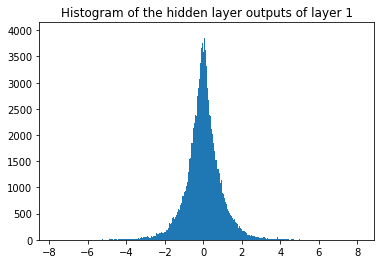

In [11]:
plt.hist(h1,bins='auto')  
plt.title("Histogram of the hidden layer outputs of layer 1")
plt.show()

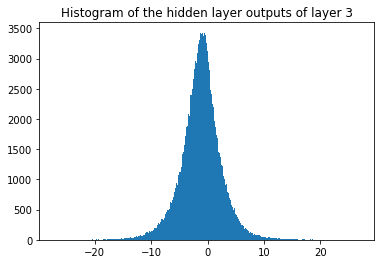

In [12]:
plt.hist(h3,bins='auto')  
plt.title("Histogram of the hidden layer outputs of layer 3")
plt.show()

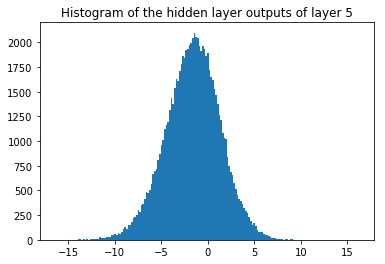

In [13]:
plt.hist(h5,bins='auto')  
plt.title("Histogram of the hidden layer outputs of layer 5")
plt.show()

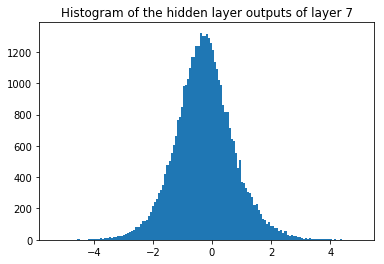

In [14]:
plt.hist(h7,bins='auto')  
plt.title("Histogram of the hidden layer outputs of layer 7")
plt.show()

### Normalize

In [15]:
def norm_BN(x, mean, var):
    '''
    x: input of BN, size 10*16*32*32
    mean: average running_mean of BN
    var: average running_var of BN, std is its square root
    '''
    norm = (x - mean) / np.sqrt(var)
    return norm

In [16]:
mean1 = np.mean(model.bn1.running_mean.numpy()) 
var1 = np.mean(model.bn1.running_var.numpy()) 

mean3 = np.mean(model.layer1[0].bn2.running_mean.numpy()) 
var3 = np.mean(model.layer1[0].bn2.running_var.numpy())

mean5 = np.mean(model.layer2[0].bn2.running_mean.numpy())
var5 = np.mean(model.layer2[0].bn2.running_var.numpy())

mean7 = np.mean(model.layer3[0].bn2.running_mean.numpy())
var7 = np.mean(model.layer3[0].bn2.running_var.numpy())

In [17]:
h1_normed = norm_BN(h1, mean1, var1)
h3_normed = norm_BN(h3, mean3, var3)
h5_normed = norm_BN(h5, mean5, var5)
h7_normed = norm_BN(h7, mean7, var7)

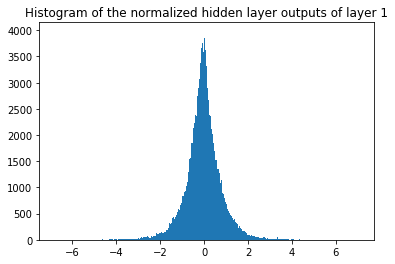

In [19]:
plt.hist(h1_normed, bins='auto')  
plt.title("Histogram of the normalized hidden layer outputs of layer 1")
plt.show()

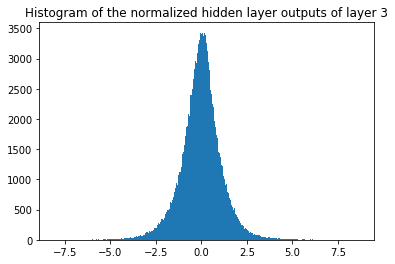

In [31]:
plt.hist(h3_normed, bins='auto')  
plt.title("Histogram of the normalized hidden layer outputs of layer 3")
plt.show()

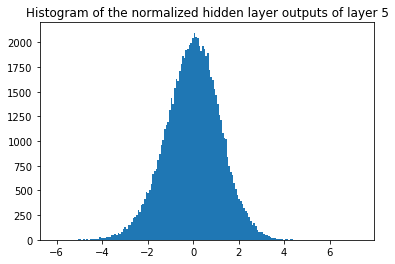

In [21]:
plt.hist(h5_normed, bins='auto')  
plt.title("Histogram of the normalized hidden layer outputs of layer 5")
plt.show()

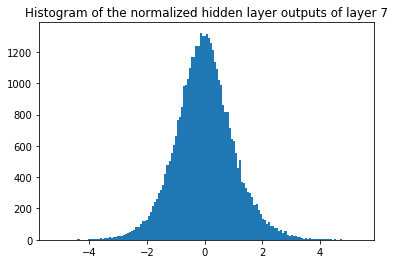

In [22]:
plt.hist(h7_normed, bins='auto')  
plt.title("Histogram of the normalized hidden layer outputs of layer 7")
plt.show()

### Comparison

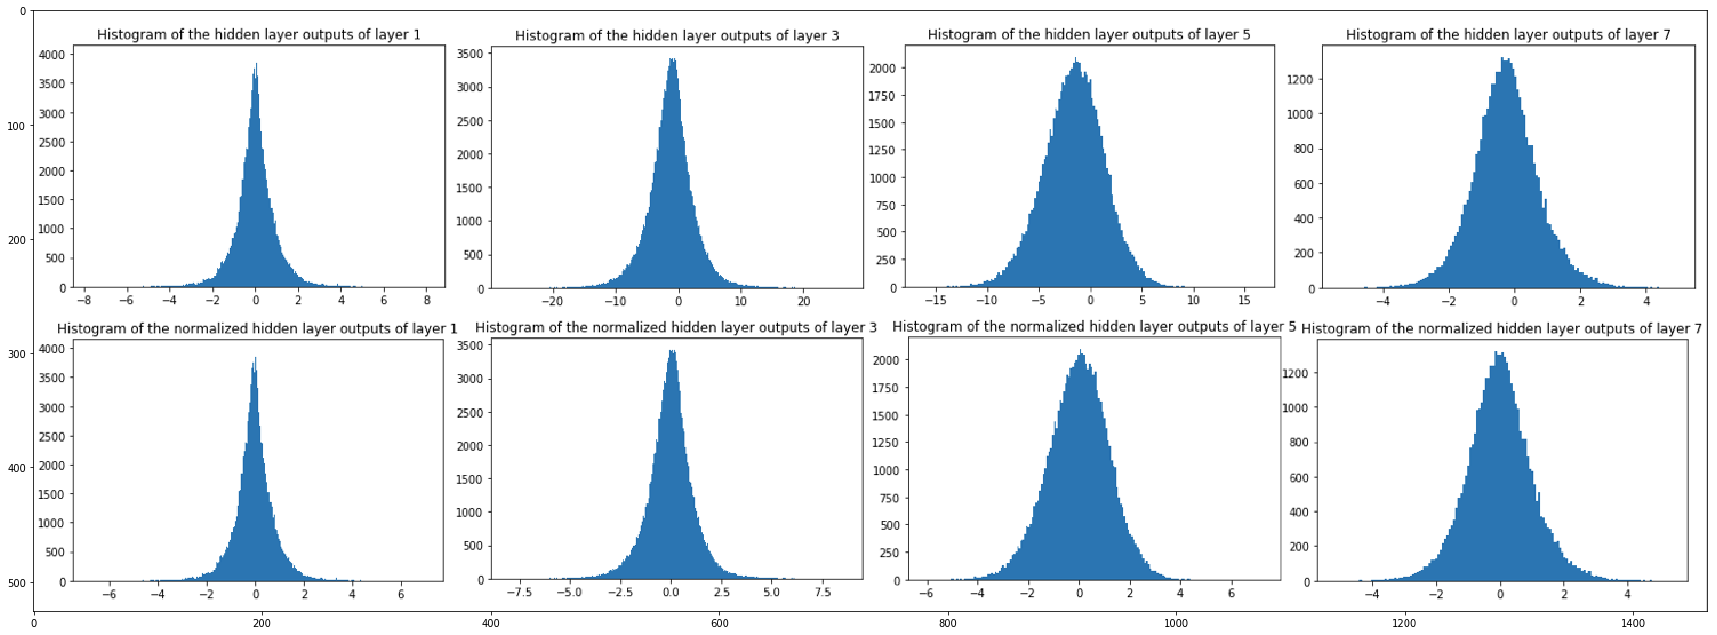

In [42]:
png = plt.imread('histogram.png')
plt.figure(figsize = (30,15))
plt.imshow(png, interpolation='nearest')

We can see that after normalization, the mean of outputs from each layer is around 0 with a std around 1, i.e., all the layer output has almost same distribution. This will makes the cost function more spherical and the learning process more stable.

## 3(b) PlainNoBnNet8

In [43]:
def plot(logfile):
    with open(logfile, 'r') as f:
        line = f.readlines()
        
    train_error = []
    for i in range(len(line)):
        if 'Training Prec' in line[i]:
            line_word = line[i].split()
            train_error.append(100.0 - float(line_word[3]))
    
    test_error = []
    for i in range(len(line)):
        if 'Testing Prec' in line[i]:
            line_word = line[i].split()
            test_error.append(100.0 - float(line_word[3]))
            
    val_loss = []
    for i in range(len(line)):
        if 'Test:' in line[i]:
            line_word = line[i].split()
            val_loss.append(float(line_word[6]))
            

    train_loss = []
    for i in range(len(line)):
        if 'Epoch' in line[i]:
            line_word = line[i].split()
            train_loss.append(float(line_word[11]))
            
    x = np.linspace(1,len(train_error),len(train_error))
    plt.plot(x,train_error,label='training error')
    plt.plot(x,test_error,label='testing error')
    plt.xlabel('epoch')
    plt.ylabel('error(%)')
    plt.legend()
            
    return train_error, test_error, train_loss, val_loss

### Plot of error curves of PlainNet 8

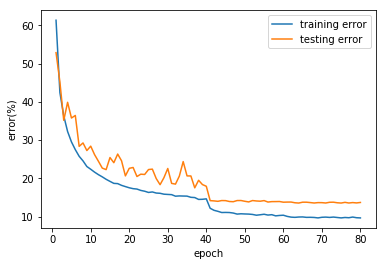

In [47]:
train, test, _, _ = plot('log_plain8.txt')

### Train PlainNoBnNet8

In [ ]:
! python main.py -a plainnet8 2>&1 | tee log_plain8_noBN.txt

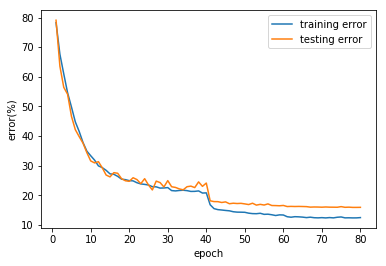

In [53]:
train_noBN, test_noBN, _, _ = plot('log_plain8_noBN.txt')

### Comparison

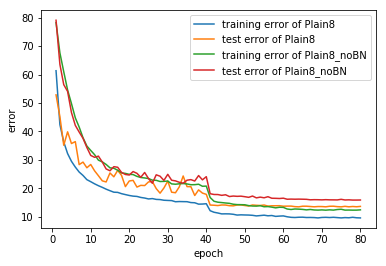

In [55]:
x = np.linspace(1,80,80)
plt.plot(x,train,label = 'training error of Plain8')
plt.plot(x,test,label = 'test error of Plain8')
plt.plot(x,train_noBN,label = 'training error of Plain8_noBN')
plt.plot(x,test_noBN,label = 'test error of Plain8_noBN')
plt.xlabel('epoch')
plt.ylabel('error')
plt.legend()

- From the error curve above, we can see that both training error and test error of PlainNoBnNet8 are higher than those in PlainNet8 with batch normalization.
- Final test error of PlainNet 8 is 13.68%, final test error for PlainNoBnNet8 is 15.93%. And this is only 8 layers.
- We can see that PlainNet8's error starts to decrease a lot since epoch 5, however, large decreasing starts at about epoch 10 for PlainNoBnNet8. BN actually speeds up the optimization process.
- Thus, batch normalization indeed makes the learning more stable and produces a better result.

## 3(c) PlainNoBnNet20

### Train PlainNoBnNet20

In [58]:
! python main.py -a plainnet20 2>&1 | tee log_plain20_noBN.txt

Building CIFAR-10 data loader with 1 workers
Files already downloaded and verified
CIFAR-10 training data size: 50000
Files already downloaded and verified
CIFAR-10 testing data size: 10000
=> creating model 'plainnet20'
Epoch: [0/80][0/250]	LR: 0.1	Time 1.960 (1.960)	Data 0.147 (0.147)	Loss 2.3051 (2.3051)	Prec@1 10.000 (10.000)
Epoch: [0/80][100/250]	LR: 0.1	Time 0.063 (0.061)	Data 0.051 (0.031)	Loss 2.2924 (2.3040)	Prec@1 11.000 (9.921)
Epoch: [0/80][200/250]	LR: 0.1	Time 0.036 (0.048)	Data 0.025 (0.028)	Loss 2.3097 (2.3031)	Prec@1 9.000 (10.177)
 * Training Prec@1 10.160
Test: [0/50]	Time 0.214 (0.214)	Loss 2.3061 (2.3061)	Prec@1 7.000 (7.000)
 * Testing Prec@1 10.000
Epoch: [1/80][0/250]	LR: 0.1	Time 0.233 (0.233)	Data 0.220 (0.220)	Loss 2.3003 (2.3003)	Prec@1 13.000 (13.000)
Epoch: [1/80][100/250]	LR: 0.1	Time 0.031 (0.039)	Data 0.021 (0.028)	Loss 2.2994 (2.3038)	Prec@1 13.000 (10.054)
Epoch: [1/80][200/250]	LR: 0.1	Time 0.038 (0.037)	Data 0.027 (0.027)	Loss 2.3031 (2.3039)	Prec@

Epoch: [17/80][200/250]	LR: 0.1	Time 0.033 (0.036)	Data 0.024 (0.026)	Loss 2.3035 (2.3035)	Prec@1 11.000 (10.147)
 * Training Prec@1 10.110
Test: [0/50]	Time 0.150 (0.150)	Loss 2.3017 (2.3017)	Prec@1 14.000 (14.000)
 * Testing Prec@1 10.000
Epoch: [18/80][0/250]	LR: 0.1	Time 0.237 (0.237)	Data 0.226 (0.226)	Loss 2.3057 (2.3057)	Prec@1 8.500 (8.500)
Epoch: [18/80][100/250]	LR: 0.1	Time 0.034 (0.035)	Data 0.024 (0.024)	Loss 2.3002 (2.3038)	Prec@1 9.500 (9.738)
Epoch: [18/80][200/250]	LR: 0.1	Time 0.034 (0.035)	Data 0.023 (0.025)	Loss 2.3020 (2.3037)	Prec@1 9.000 (9.953)
 * Training Prec@1 9.976
Test: [0/50]	Time 0.130 (0.130)	Loss 2.3044 (2.3044)	Prec@1 7.000 (7.000)
 * Testing Prec@1 10.000
Epoch: [19/80][0/250]	LR: 0.1	Time 0.272 (0.272)	Data 0.258 (0.258)	Loss 2.3065 (2.3065)	Prec@1 9.000 (9.000)
Epoch: [19/80][100/250]	LR: 0.1	Time 0.037 (0.037)	Data 0.025 (0.027)	Loss 2.3001 (2.3038)	Prec@1 10.000 (10.064)
Epoch: [19/80][200/250]	LR: 0.1	Time 0.030 (0.035)	Data 0.020 (0.025)	Loss 2.

Epoch: [35/80][100/250]	LR: 0.1	Time 0.036 (0.038)	Data 0.026 (0.028)	Loss 2.3036 (2.3039)	Prec@1 12.500 (9.698)
Epoch: [35/80][200/250]	LR: 0.1	Time 0.033 (0.036)	Data 0.023 (0.026)	Loss 2.3036 (2.3039)	Prec@1 7.500 (9.853)
 * Training Prec@1 9.956
Test: [0/50]	Time 0.150 (0.150)	Loss 2.3015 (2.3015)	Prec@1 14.000 (14.000)
 * Testing Prec@1 10.000
Epoch: [36/80][0/250]	LR: 0.1	Time 0.229 (0.229)	Data 0.217 (0.217)	Loss 2.3022 (2.3022)	Prec@1 10.000 (10.000)
Epoch: [36/80][100/250]	LR: 0.1	Time 0.031 (0.037)	Data 0.021 (0.027)	Loss 2.3031 (2.3039)	Prec@1 11.500 (9.772)
Epoch: [36/80][200/250]	LR: 0.1	Time 0.045 (0.035)	Data 0.034 (0.025)	Loss 2.2994 (2.3037)	Prec@1 9.000 (9.896)
 * Training Prec@1 9.928
Test: [0/50]	Time 0.103 (0.103)	Loss 2.3003 (2.3003)	Prec@1 14.000 (14.000)
 * Testing Prec@1 10.000
Epoch: [37/80][0/250]	LR: 0.1	Time 0.222 (0.222)	Data 0.210 (0.210)	Loss 2.3014 (2.3014)	Prec@1 10.000 (10.000)
Epoch: [37/80][100/250]	LR: 0.1	Time 0.035 (0.038)	Data 0.025 (0.029)	Loss

 * Testing Prec@1 10.000
Epoch: [53/80][0/250]	LR: 0.01	Time 0.169 (0.169)	Data 0.155 (0.155)	Loss 2.3032 (2.3032)	Prec@1 11.500 (11.500)
Epoch: [53/80][100/250]	LR: 0.01	Time 0.034 (0.039)	Data 0.024 (0.028)	Loss 2.3033 (2.3028)	Prec@1 7.000 (9.950)
Epoch: [53/80][200/250]	LR: 0.01	Time 0.034 (0.038)	Data 0.025 (0.028)	Loss 2.3022 (2.3028)	Prec@1 9.500 (9.863)
 * Training Prec@1 9.834
Test: [0/50]	Time 0.127 (0.127)	Loss 2.3025 (2.3025)	Prec@1 9.500 (9.500)
 * Testing Prec@1 10.000
Epoch: [54/80][0/250]	LR: 0.01	Time 0.150 (0.150)	Data 0.138 (0.138)	Loss 2.3030 (2.3030)	Prec@1 8.500 (8.500)
Epoch: [54/80][100/250]	LR: 0.01	Time 0.033 (0.034)	Data 0.023 (0.024)	Loss 2.3038 (2.3027)	Prec@1 7.500 (9.990)
Epoch: [54/80][200/250]	LR: 0.01	Time 0.033 (0.034)	Data 0.023 (0.024)	Loss 2.3034 (2.3027)	Prec@1 7.500 (9.836)
 * Training Prec@1 9.754
Test: [0/50]	Time 0.095 (0.095)	Loss 2.3033 (2.3033)	Prec@1 7.500 (7.500)
 * Testing Prec@1 10.000
Epoch: [55/80][0/250]	LR: 0.01	Time 0.242 (0.242)	D

 * Training Prec@1 9.680
Test: [0/50]	Time 0.126 (0.126)	Loss 2.3025 (2.3025)	Prec@1 14.000 (14.000)
 * Testing Prec@1 10.000
Epoch: [71/80][0/250]	LR: 0.001	Time 0.216 (0.216)	Data 0.204 (0.204)	Loss 2.3027 (2.3027)	Prec@1 7.000 (7.000)
Epoch: [71/80][100/250]	LR: 0.001	Time 0.032 (0.038)	Data 0.022 (0.028)	Loss 2.3027 (2.3026)	Prec@1 12.500 (9.886)
Epoch: [71/80][200/250]	LR: 0.001	Time 0.033 (0.037)	Data 0.021 (0.026)	Loss 2.3025 (2.3026)	Prec@1 11.500 (9.687)
 * Training Prec@1 9.634
Test: [0/50]	Time 0.146 (0.146)	Loss 2.3026 (2.3026)	Prec@1 13.000 (13.000)
 * Testing Prec@1 10.000
Epoch: [72/80][0/250]	LR: 0.001	Time 0.164 (0.164)	Data 0.149 (0.149)	Loss 2.3026 (2.3026)	Prec@1 9.000 (9.000)
Epoch: [72/80][100/250]	LR: 0.001	Time 0.032 (0.036)	Data 0.022 (0.025)	Loss 2.3026 (2.3026)	Prec@1 10.500 (9.901)
Epoch: [72/80][200/250]	LR: 0.001	Time 0.033 (0.035)	Data 0.023 (0.024)	Loss 2.3025 (2.3026)	Prec@1 10.500 (9.716)
 * Training Prec@1 9.672
Test: [0/50]	Time 0.133 (0.133)	Loss 2.

### Plot of PlainNoBnNet20

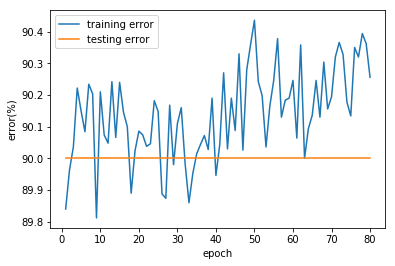

In [59]:
train_noBN, test_noBN, _, _ = plot('log_plain20_noBN.txt')

### Plot of PlainNet20

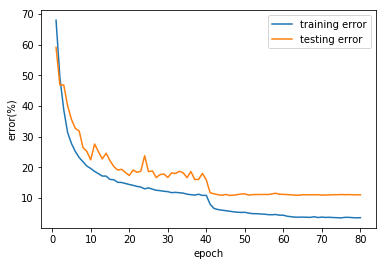

In [60]:
train, test, _, _ = plot('log_plain20.txt')

- We can see it's so obvious that without BN, PlainNoBnNet20 barely learns anything with learning rate = 0.1. Maybe use smaller learning rate will give us some result.
- Batch normalization narrows valleys in the cost function, allows us to use higher learning rate and improves the accuracy when network is deep and features are unbalanced.